In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import uproot as up

/hpc/applications/anaconda/3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
branch_names=['trilep_type',
              'lep_ID_0','lep_ID_1','lep_ID_2',
              'lep_Pt_0','lep_Pt_1','lep_Pt_2',
              'lep_E_0','lep_E_1','lep_E_2','Ptll01','Ptll02','Ptll12',
              'lep_Eta_0','lep_Eta_1','lep_Eta_2',
              'lep_Phi_0','lep_Phi_1','lep_Phi_2',
              'lep_isolationPflowLoose_0','lep_isolationPflowLoose_1','lep_isolationPflowLoose_2',
              'lep_Mtrktrk_atPV_CO_0','lep_Mtrktrk_atPV_CO_1','lep_Mtrktrk_atPV_CO_2',
              'lep_RadiusCO_0','lep_RadiusCO_1','lep_RadiusCO_2',
              'met_met','Mll01','Mll02','Mll12','best_Z_Mll','minOSSFMll','minOSMll',
              'DRll01','DRll02','DRll12',
              'HT','HT_lep','HT_jets','lead_jetPt','sublead_jetPt','lead_jetE','sublead_jetE',
              'nJets_OR','nJets_OR_DL1r_85','nTaus_OR_Pt25_RNN',
              'DRl1jmin','DRl0jmin','DRjjMax',
              'DRl0j0','DRl0j1','DRl1j0','DRl1j1','DRl2j0','DRl2j1','DRj0j1',
              'mj0j1','ml0j0','ml0j1','ml1j0','ml1j1','ml2j0','ml2j1']


signal_events = up.open("hhml_signal.root")['nominal']
#ttbar_events = up.open("ttbar.root")['nominal']

vv_events = up.open("vv.root")['nominal']
#print("Variables available: ",signal_events.keys())

df_signal = signal_events.pandas.df(branch_names)
#df_ttbar = ttbar_events.pandas.df(branch_names)
df_signal['class'] = 1

df_vv    = vv_events.pandas.df(branch_names)
df_vv['class'] = 0

#df_signal['class'] =0
#df_ttbar['class'] =1
#df_vv['class']=2


print("Total Signal events: ",len(df_signal))
#print("Total ttbar events: ",len(df_ttbar))
print("Total VV events: ",len(df_vv))


df = df_vv.append(df_signal)
df = df.sample(frac=1).reset_index(drop=True) # Sort 

# We can rename variables if desired
#df = df.rename(columns={'ss.x_cm':'x'})

# Get some simple derived variables (more human-interpretable; not necessary for deep learning applications, may help simpler algorithms)
#df['log10s2Area_phd'] = np.log10(df['s2Area_phd'])
#df['r_cm'] = np.sqrt(df['x_cm']**2+df['y_cm']**2)

# Separate class info from inputs (no cheating!)
y_df = df.pop('class')



Total Signal events:  25706
Total VV events:  504022


In [ ]:
#signal_events.keys()

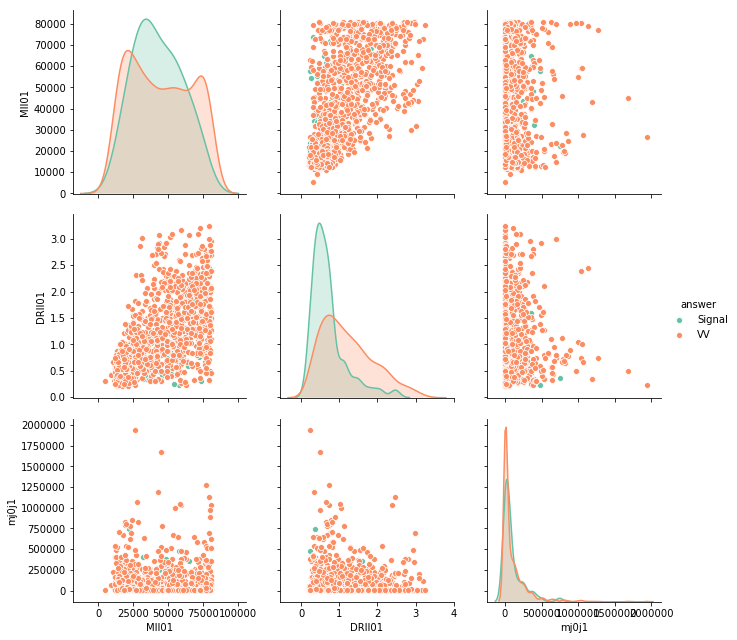

In [5]:
import seaborn as sns
# Seaborn is a nice package for data visualization - it has many pre-defined plotting functions and looks pretty

# Only keep some variables for training
variable_names = ['Mll01','DRll01','mj0j1']
#variable_names = branch_names

# Make a new column where the answer is a category with the appropriate name, for plotting
#df['answer']='VV'
df.loc[y_df==1,'answer']='Signal'
df.loc[y_df==0,'answer']='VV'
#df.loc[y_df==2,'answer']='VV'
df['answer'] = df['answer'].astype('category')

# Plot input distributions and visualize correlations; only look at a subset of events for scatter plotting
g = sns.pairplot(df.head(1000), vars=variable_names, hue='answer', palette="Set2", height=3) # Diagonal plots are smoothed using kernel density estimator; skip with diag_kind='hist'

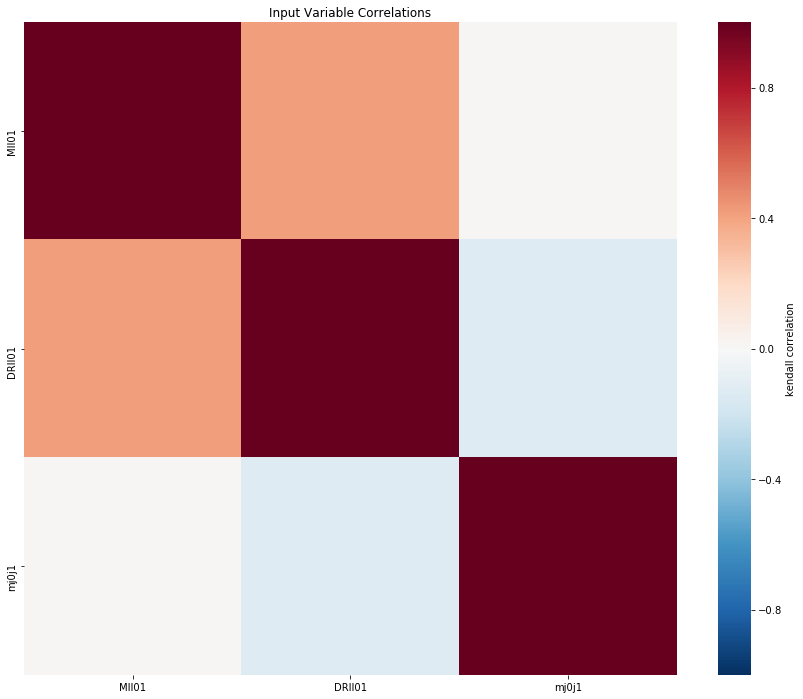

In [12]:
# Show correlation coefficients across variables
# Different correlation coefficients compared here: https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall
# Generically, Kendall only requires a monotonic relationship (not linear) and is more robust to outliers, as it only uses rank information (quantiles)
# Pearson includes a bit more information but assumes normal distributions and linear relationships
#method = 'pearson'
method = 'kendall'
correlations = df[variable_names].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (15,12))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reduce to only the variables we want to train on, use numpy array format
X_unscaled = np.array(df[variable_names])
X_signal = np.array(df_signal[variable_names])
#X_unscaled = np.array(df[branch_names])
Y = np.array(y_df)

# Split data into training and testing (70/30 split); shuffle order, just in case the indexing of the input data carries information
# Stratify option ensures train and test split preserves percentage of samples in each class; most important when one or more classes have low stats
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X_unscaled, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Perform initial transformations - StandardScaler sets mean of each feature to 0, std to 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled) # Use same scaling transformation on test and train data (do not pick a new mean, std)
X = scaler.transform(X_unscaled)

In [21]:

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier

# Make the base classifier (single decision tree) - not yet trained, includes termination condition
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=10)
# Now combine a bunch of decision trees; number set by n_estimators. 
# The specific way samples are re-weighted is controlled by the AdaBoost algorithm
BDT = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')

# Train the BDT! One line, very fast
model = BDT.fit(x_train_unscaled, y_train) # BDT looks at each feature independently, so scaling is typically not necessary



In [20]:
BDT.predict_proba(df[x_train_unscaled].head())

KeyError: "None of [Index([ (17693.736, 0.43058944, 4489.791),  (32249.355, 1.1740202, 6895.6606),\n         (30608.438, 1.1891761, 9284.472),  (18132.277, 0.6496703, 11865.432),\n         (60005.53, 1.4768637, 6579.8926),  (29812.578, 1.3700786, 4068.6924),\n        (34051.438, 0.3976894, 28191.674),  (69832.27, 0.38344985, 204337.88),\n          (43590.83, 0.4532743, 58708.41),    (47229.91, 1.028952, 14383.003),\n       ...\n          (57875.41, 2.2813091, 92785.42),   (42035.13, 2.7759795, 12500.265),\n       (17634.115, 0.49767748, 17607.951),   (78073.57, 1.0106751, 6223.3184),\n         (47051.29, 2.0628996, 6736.8013),    (80758.27, 2.0679696, 8914.452),\n        (18405.62, 0.40515503, 56973.742),   (15249.926, 0.7044163, 7955.454),\n          (75982.59, 1.354532, 7314.0537),  (30619.027, 1.3449088, 25704.984)],\n      dtype='object', length=370809)] are in the [columns]"

In [7]:
df.head()

trilep_type  lep_ID_0  lep_ID_1  lep_ID_2       lep_Pt_0       lep_Pt_1  \
0            1     -13.0      13.0      13.0  112933.203125   47379.644531   
1            1     -13.0      13.0      13.0  125589.976562   57968.250000   
2            2      13.0     -11.0     -13.0   28382.572266   16093.433594   
3            1      13.0     -13.0     -13.0   31821.541016  270219.250000   
4            2      13.0     -13.0     -11.0   13018.934570  163817.828125   

        lep_Pt_2        lep_E_0        lep_E_1        lep_E_2  ...    DRl2j1  \
0  102948.843750  129124.671875   60054.558594  117842.468750  ...  2.956778   
1   31560.095703  473733.406250  171997.171875   81141.781250  ...  4.097661   
2   18780.908203   35240.054688   62836.132812   28078.835938  ...  3.541865   
3   16909.480469   38402.417969  558789.875000   20169.890625  ...  1.929689   
4  188080.328125   30785.789062  221516.609375  213798.828125  ...  0.517214   

     DRj0j1          mj0j1          ml0j0          ml0j1          ml1j0  \
0  1.736049    6284.780762  138984.359375     101.303703  107414.039062   
1  3.025676  362226.187500  466802.406250  341672.562500  296536.000000   
2  5.761423  262286.750000  116722.484375   65869.390625  168034.796875   
3  3.161032  588649.812500  233373.437500   96937.664062  576252.250000   
4  1.526230    2816.378418   42152.625000     105.524368  171129.906250   

           ml1j1          ml2j0          ml2j1  answer  
0     105.100052  105977.375000     102.641685      VV  
1  201685.046875  115143.984375  166539.359375      VV  
2   11737.736328   99511.804688   58612.667969      VV  
3  429175.156250  103286.328125   75380.992188      VV  
4      98.622108   93779.562500     -41.361538      VV  

[5 rows x 66 columns]

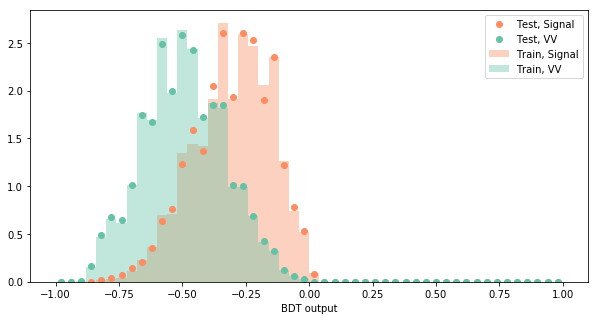

In [16]:
y_pred_test = model.decision_function(x_test_unscaled)
y_pred_DD_train = model.decision_function(x_train_unscaled[y_train==1])
y_pred_DD_test = model.decision_function(x_test_unscaled[y_test==1])
y_pred_ch3t_train = model.decision_function(x_train_unscaled[y_train==0])
y_pred_ch3t_test = model.decision_function(x_test_unscaled[y_test==0])

n_bins=50
hist_range=(-1.0,1.0)
DD_color = sns.color_palette("Set2")[1]
CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,5))
plt.hist(y_pred_DD_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=DD_color,label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_DD_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=DD_color,label="Test, Signal")

plt.hist(y_pred_ch3t_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=CH3T_color,label="Train, VV")
counts,bin_edges = np.histogram(y_pred_ch3t_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=CH3T_color,label="Test, VV")

plt.legend()
plt.xlabel('BDT output')
plt.show()

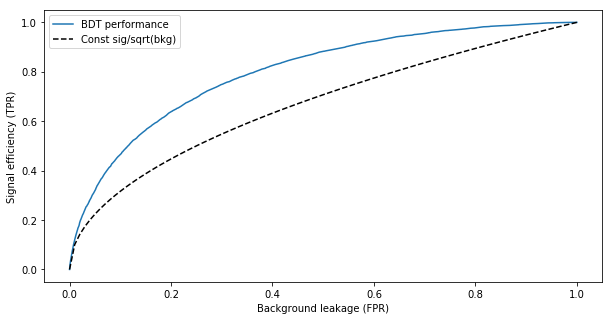

In [17]:
# Use the test data, since the training data can "cheat" by overfitting
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_pred_test, pos_label=1) # Signal class set to 1

plt.figure(figsize=(10,5))
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

n_pts = 100
bkg_eff = np.linspace(0,1,n_pts)
sig_fixed = np.sqrt(bkg_eff)
plt.plot(bkg_eff, sig_fixed, label="Const sig/sqrt(bkg)", color='black', linestyle='--')
plt.legend()
plt.show()


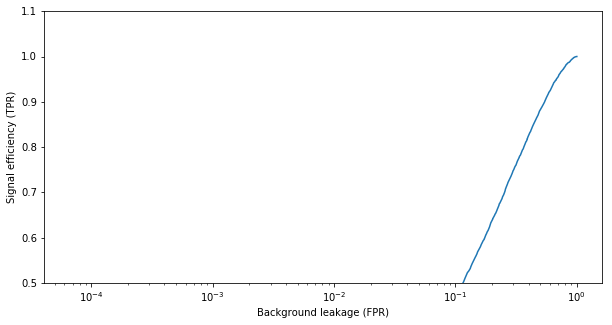

In [18]:


plt.figure(figsize=(10,5))
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")
plt.xscale('log')
plt.ylim((0.5,1.1))
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')
plt.show()



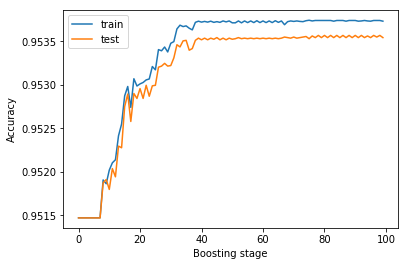

In [58]:
# Get accuracy, ROC AUC vs boosting stage, i.e. number of trees
test_acc, train_acc = [], []
test_auc, train_auc = [], []
for train_predict in model.staged_predict(x_train_unscaled):
    train_acc.append(accuracy_score(y_train, train_predict)) # Can add sample weights here
    
for train_predict in model.staged_decision_function(x_train_unscaled):
    train_auc.append(roc_auc_score(y_train, train_predict))
    
for test_predict in model.staged_predict(x_test_unscaled):
    test_acc.append(accuracy_score(y_test, test_predict)) # Can add sample weights here
    
for test_predict in model.staged_decision_function(x_test_unscaled):
    test_auc.append(roc_auc_score(y_test, test_predict))
    
plt.plot(train_acc,label="train")
plt.plot(test_acc,label="test")
plt.xlabel("Boosting stage")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

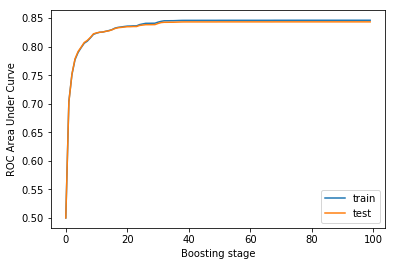

In [59]:
plt.plot(train_auc,label="train")
plt.plot(test_auc,label="test")
plt.xlabel("Boosting stage")
plt.ylabel("ROC Area Under Curve")
plt.legend()
plt.show()


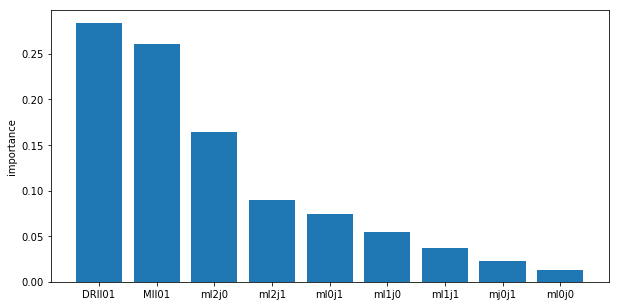

In [60]:
# Get feature ranking
importances = np.array(list(zip(variable_names, model.feature_importances_)))
# Sort in order of importance (then reverse so most important is first)
importances = importances[importances[:, 1].argsort()]
importances = importances[::-1]

# Plot variable importances
plt.figure(figsize=(10,5))
plt.bar(importances[:,0],importances[:,1].astype(float),bottom=0)
plt.ylabel("importance")
plt.show()

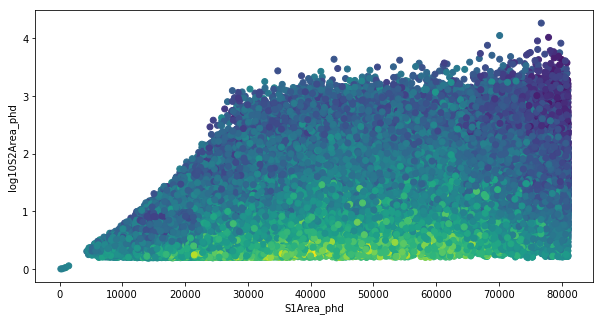

In [61]:
plt.figure(figsize=(10,5))
plt.scatter(x_test_unscaled[:,0],x_test_unscaled[:,1],c=y_pred_test)
plt.ylabel('log10S2Area_phd')
plt.xlabel('S1Area_phd')
plt.show()

In [19]:
import xgboost
# train, test = train_test_split(rdf, test_size=0.25, random_state=123)
# dtrain = xgb.DMatrix(train[['rsq', 'dt_us', 'phi'  ]], label = train['class'])
# dtest = xgb.DMatrix(test[['rsq', 'dt_us', 'phi' ]], label = test['class'])
#x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X_unscaled, Y, test_size=0.3, random_state=0, shuffle=True)
dtrain = xgboost.DMatrix(x_train_unscaled, label = y_train)
dtest = xgboost.DMatrix(x_test_unscaled, label = y_test)
wpos = (y_train).sum()
wneg = ((1-y_train)).sum()
#In XGBoost (and the previous BDT implementations) you can set the hyperparameters.
param = {'max_depth':6, # The trees will grow to this depth, so maximum 2^6 leaves
         'eta':0.1, #shrink the weight of each stage by this amount (geometric series)
         'objective':'binary:logistic', # Probably don't mess with this
         'subsample':.9, #"Bagging" by randomly sampling rows with replacement this fraction of events in each stage. 
         'colsample_bylevel':1, #if you want to use "Random Forests" which resample on the columns, change to a number in [0,1]. 
                                 #Change "bylevel" to "bytree" or "bynode" to change when this resampling occurs (stage, depth, or node)
         'min_split_loss':1, #This is "Gamma" in the XGBoost paper, a proposed split needs to improve the loss function by this amount 
         'lambda':1, #L2 regularization. Can think of this as preventing the BDT from separating leaf too aggressively. 
                     #Probably don't need to tweak too much, the topological regularizers tend to have bigger effects. 
         #'monotone_constraints': '(-1,0,0)' # this one is really cool. If you know that you want the classifier
                                             #to generally increase (decrease) in a given direction, you can specify it,
                                             #and then the output will be monotonically increasing (decreasing)
        'scale_pos_weight':max(wneg,wpos)/min(wpos, wneg)
        }
num_round = 100 #maximum number of rounds
progress = dict()
watchlist =  [ (dtrain, 'train'),(dtest, 'validation')] #as it is training, the BDT will evaluate on these datasets
bst = xgboost.train(param, dtrain, num_round,
                    evals = watchlist,
                    verbose_eval = 5 ,
                   # early_stopping_rounds = 50, #You can set this to stop training when the validation set starts to turn over (overtraining is occurring)
                    evals_result=progress)
for x in ['gain', 'weight', 'cover', 'total_gain', 'total_cover']:
    print('feature %s : %s'%(x,bst.get_score(importance_type = x)))
#save the model! This will allow us to read it back in later
bst.save_model('fb_bdt.xgb')
# We can later load the model back in with code like this:
#bst = xgb.Booster({'nthread': 4})  # init model
#bst.load_model('model.bin')  # load data

[0]	train-error:0.29657	validation-error:0.29887
[5]	train-error:0.28782	validation-error:0.29058
[10]	train-error:0.28040	validation-error:0.28323
[15]	train-error:0.27437	validation-error:0.27734
[20]	train-error:0.27496	validation-error:0.27764
[25]	train-error:0.27224	validation-error:0.27509
[30]	train-error:0.27072	validation-error:0.27359
[35]	train-error:0.27052	validation-error:0.27340
[40]	train-error:0.26998	validation-error:0.27304
[45]	train-error:0.26923	validation-error:0.27231
[50]	train-error:0.26928	validation-error:0.27242
[55]	train-error:0.26876	validation-error:0.27204
[60]	train-error:0.26768	validation-error:0.27113
[65]	train-error:0.26714	validation-error:0.27050
[70]	train-error:0.26668	validation-error:0.27025
[75]	train-error:0.26640	validation-error:0.27013
[80]	train-error:0.26564	validation-error:0.26960
[85]	train-error:0.26559	validation-error:0.26947
[90]	train-error:0.26527	validation-error:0.26910
[95]	train-error:0.26483	validation-error:0.26872
[9

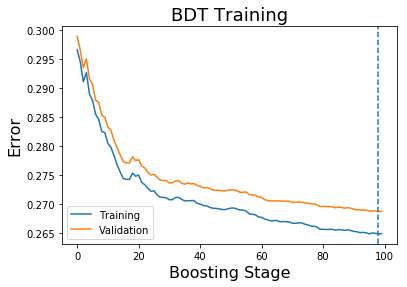

In [20]:
plt.plot(progress['train']['error'], label='Training')
plt.plot(progress['validation']['error'], label ='Validation')
plt.axvline(np.argmin(progress['validation']['error']), ls = '--')
plt.xlabel('Boosting Stage', fontsize = 16)
plt.ylabel('Error', fontsize = 16)
plt.title('BDT Training', fontsize = 18)
plt.legend()

In [22]:
# What do the decision function outputs look like for signal vs background?
y_pred_test = bst.predict(dtest)
y_pred_train = bst.predict(dtrain)
y_pred_DD_train = y_pred_train[y_train==1]
y_pred_DD_test = y_pred_test[y_test==1]
y_pred_ch3t_train = y_pred_train[y_train==0]
y_pred_ch3t_test = y_pred_test[y_test==0]
#w_DD_train = w_train[y_train==1]
#w_DD_test = w_test[y_test==1]
#w_ch3t_train = w_train[y_train==0]
#w_ch3t_test = w_test[y_test==0]

n_bins=100
hist_range=(0,1)
DD_color = sns.color_palette("Set2")[1]
CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,5))
plt.hist(y_pred_DD_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=DD_color,label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_DD_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=DD_color,label="Test, Signal")

plt.hist(y_pred_ch3t_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=CH3T_color,label="Train, VV")
counts,bin_edges = np.histogram(y_pred_ch3t_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.semilogy(bin_centers, counts,marker="o",linestyle="None",color=CH3T_color,label="Test, VV")

plt.legend(loc = (.2, .7))
plt.xlabel('BDT output')
plt.ylim(0.1, 100)
plt.show()

NameError: name 'bst' is not defined

In [65]:


alpha = 1- np.sum(y_pred_DD_test)/len(y_pred_DD_test)
beta =  np.sum(y_pred_ch3t_test)/len(y_pred_ch3t_test)
print('Misclassification: %.3f %.3f'%(alpha, beta))



Misclassification: 0.320 0.296


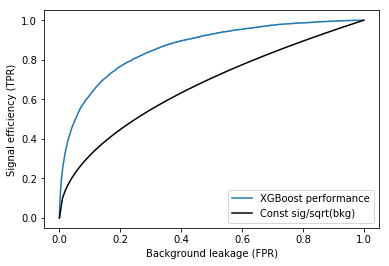

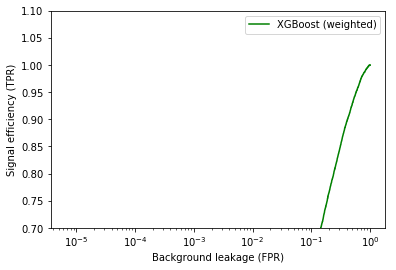

In [68]:
XGB_FPR_test, XGB_TPR_test, XGB_TH_test = roc_curve(y_test, y_pred_test, pos_label=1) # Signal class set to 1
plt.plot(XGB_FPR_test, XGB_TPR_test, label="XGBoost performance")
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

#n_pts = 100
#bkg_eff = np.linspace(0,1,n_pts)
#sig_fixed = np.sqrt(bkg_eff)
plt.plot(bkg_eff, sig_fixed, label="Const sig/sqrt(bkg)", color='black')
plt.legend()
plt.show()

plt.plot(XGB_FPR_test, XGB_TPR_test, label="XGBoost (weighted)", color='green')
#plt.plot(NN_FPR_test, NN_TPR_test, label="NN (weighted)", color='orange')
#plt.plot(BDT_weighted_FPR_test, BDT_weighted_TPR_test, label="sklearn BDT (weighted)", color='blue')
plt.xscale('log')
plt.ylim((0.7,1.1))
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')
plt.legend()

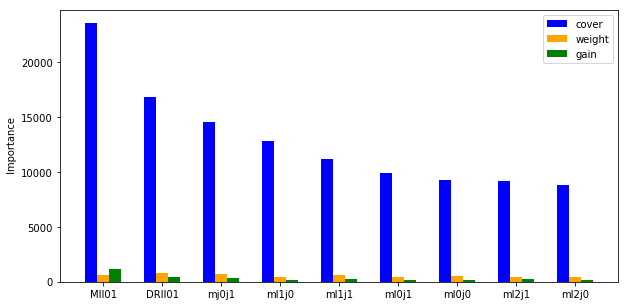

In [69]:
# Get feature ranking
index = np.arange(len(variable_names))
bar_width = .2
# Sort in order of importance (then reverse so most important is first)
sorted_order = None
# Plot variable importances
plt.figure(figsize=(10,5))
plt.ylabel(" Importance")
colors = ['b', 'orange', 'g']
for k, importance in enumerate(['cover', 'weight', 'gain']):
    importances =  np.array(list(bst.get_score(importance_type = importance).values()))
#     importances
#     importances = importances / np.max(importances)
    if sorted_order is None:
        sorted_order = importances.argsort()[::-1]
    importances = importances[sorted_order]
    plt.bar(index + k*bar_width,importances.astype(float), bar_width,bottom=0, label = importance, color = colors[k] )
#     plt.gca().twinx()
plt.xticks(index + bar_width, np.array(variable_names)[sorted_order])
plt.legend(loc = 'best')
plt.show()

In [35]:
#Hyper parameter optimization
#https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        #'n_estimators': 100,
        'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
        'objective':hp.choice('objective',['multi:softprob','multi:softmax']),
        #'objective':hp.choice('objective',['binary:logistic','binary:hinge']),
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(num_class=2,
                    objective= space['objective'],
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),tree_method='gpu_hist')
    
    #evaluation = [( X_train, y_train), ( X_test, y_test)]
    evaluation = [( x_train_unscaled, y_train), ( x_test_unscaled, y_test)]

    clf.fit(x_train_unscaled, y_train,
            eval_set=evaluation,eval_metric="merror",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_test_unscaled)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [36]:
trials = Trials()

best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest, max_evals = 100,trials = trials)

SCORE:                                                 
0.9514721336026529                                     
SCORE:                                                                            
0.9514721336026529                                                                
SCORE:                                                                            
0.9514721336026529                                                                
SCORE:                                                                            
0.9514721336026529                                                                
SCORE:                                                                            
0.9514721336026529                                                                
SCORE:                                                                            
0.9514721336026529                                                                
SCORE:                                                    

SCORE:                                                                             
0.9514721336026529                                                                 
SCORE:                                                                             
0.9514721336026529                                                                 
SCORE:                                                                             
0.9514721336026529                                                                 
SCORE:                                                                             
0.9514721336026529                                                                 
SCORE:                                                                             
0.9514721336026529                                                                 
SCORE:                                                                             
0.9514721336026529                                                          

0.9514721336026529                                                                 
SCORE:                                                                             
0.9514721336026529                                                                 
SCORE:                                                                             
0.9514721336026529                                                                 
100%|██████████| 100/100 [00:41<00:00,  2.39trial/s, best loss: -0.9514721336026529]


In [25]:
best_hyperparams

{'colsample_bytree': 0.7190910224173006,
 'gamma': 7.2944378078793735,
 'max_depth': 9.0,
 'min_child_weight': 10.0,
 'n_estimators': 68.0,
 'objective': 0,
 'reg_alpha': 150.0,
 'reg_lambda': 0.575780151633107}

In [26]:
best_hyperparams['num_class'] = 2
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['n_estimators'] = int (best_hyperparams['n_estimators'])
best_hyperparams['tree_method'] = 'gpu_hist'
best_hyperparams['objective'] = "multi:softprob"
clf_opt = xgb.XGBModel(**best_hyperparams)
xbgm = clf_opt.fit(x_train_unscaled, y_train)

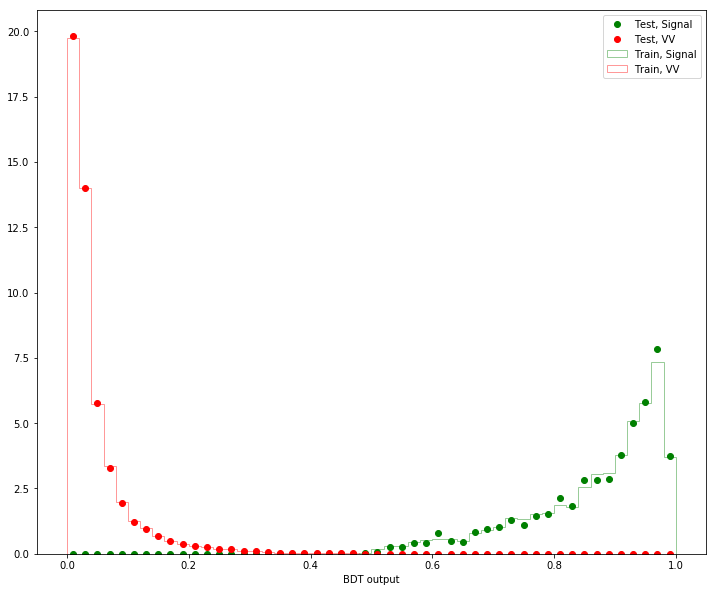

array([[0.7678796 , 0.23212038],
       [0.8404795 , 0.15952055],
       [0.92306584, 0.07693414],
       ...,
       [0.6707898 , 0.3292102 ],
       [0.98363507, 0.01636489],
       [0.8857578 , 0.11424218]], dtype=float32)

In [30]:
y_pred_vv_train = clf_opt.predict(x_train_unscaled[y_train==0])
y_pred_vv_test = clf_opt.predict(x_test_unscaled[y_test==0])
y_pred_DD_train = clf_opt.predict(x_train_unscaled[y_train==1])
y_pred_DD_test = clf_opt.predict(x_test_unscaled[y_test==1])



n_bins=50
hist_range=(0.0,1.0)
#DD_color = sns.color_palette("Set2")[1]
#CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(12,10))
plt.hist(y_pred_DD_train[:,0],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="green",label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_DD_test[:,0],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#menStd     = np.sqrt(counts)
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
#plt.errorbar(x=0, xerr =0,y=counts, yerr=menStd)
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="green",label="Test, Signal")


plt.hist(y_pred_vv_train[:,1],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="red",label="Train, VV")
counts,bin_edges = np.histogram(y_pred_vv_test[:,1],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="red",label="Test, VV")



plt.legend()
plt.xlabel('BDT output')
plt.show()

y_pred_DD_train

[[0.9562872  0.04371276]
 [0.96438164 0.03561841]
 [0.90618116 0.09381881]
 ...
 [0.9789024  0.02109768]
 [0.9073266  0.09267346]
 [0.9874205  0.0125795 ]]


<Figure size 432x288 with 0 Axes>

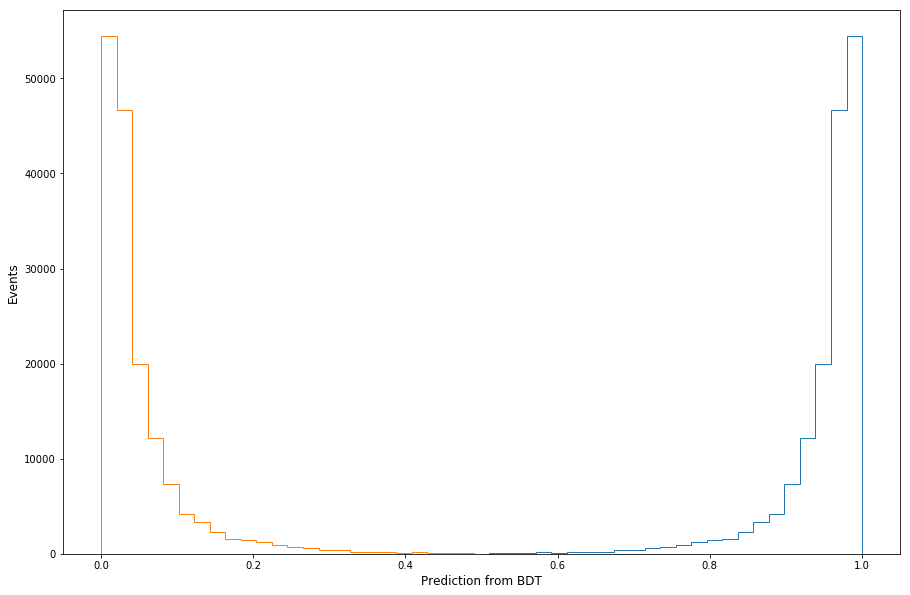

In [40]:
y_pred = clf_opt.predict(x_test_unscaled)
#y_pred = clf_opt.predict(df_vv[branch_names])
#y_pred1 = clf_opt.predict(df_signal[branch_names])
#Plot predictions
plt.figure()
plt.figure(figsize=(15,10))
plt.hist(y_pred,bins=np.linspace(0,1,50),histtype='step',label='All events')
plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events",fontsize=12)
#confusion_matrix(y_test,(y_pred>0.2))
#print([x[0] for x in y_pred],[x[1] for x in y_pred])
#y_pred
#y_pred_sig = clf_opt.predict(X_train[y_train==0])
#y_pred_sig
print(y_pred)

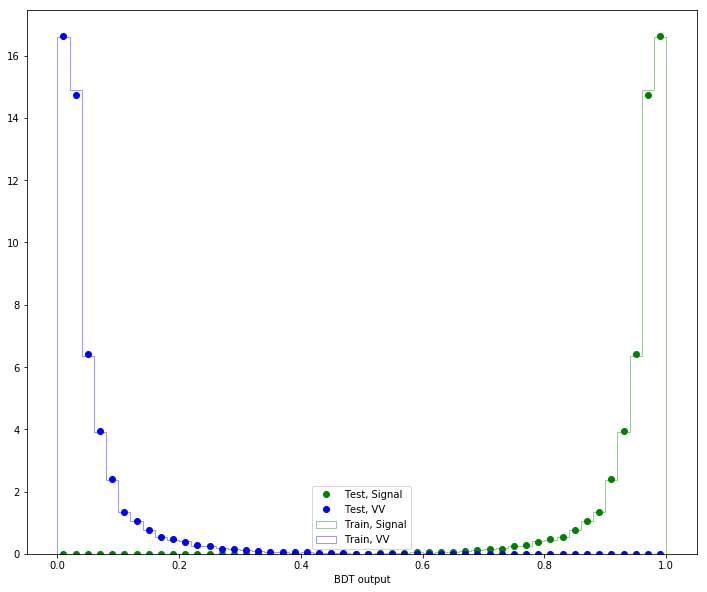

In [49]:
y_pred_opt = clf_opt.predict(x_test_unscaled)
y_pred_train_opt = clf_opt.predict(x_train_unscaled)
#y_pred_DD_test = clf.predict(X_test[y_test==1])
#y_pred_ch3t_train = clf.predict(X_train[y_train==0])
#y_pred_ch3t_test = clf.predict(X_test[y_test==0])
#y_pred_vv_train = clf.predict(X_train[y_train==2])
#y_pred_vv_test = clf.predict(X_test[y_test==2])


n_bins=50
hist_range=(0.0,1.0)
#DD_color = sns.color_palette("Set2")[1]
#CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(12,10))




#data       = np.array(np.random.rand(1000))
#y,binEdges = np.histogram(data,bins=10)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#menStd     = np.sqrt(y)
#width      = 0.05
#plt.bar(bincenters, y, width=width, color='r', yerr=menStd)
#plt.show()


plt.hist(y_pred_train_opt[:,0],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="green",label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_opt[:,0],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#menStd     = np.sqrt(counts)
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
#plt.errorbar(x=0, xerr =0,y=counts, yerr=menStd)
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="green",label="Test, Signal")


plt.hist(y_pred_train_opt[:,1],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="blue",label="Train, VV")
counts,bin_edges = np.histogram(y_pred_opt[:,1],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="blue",label="Test, VV")



plt.legend()
plt.xlabel('BDT output')
plt.show()


In [57]:
 y_pred_train_opt[:,0][0:10]


array([0.9732762 , 0.9566409 , 0.98362154, 0.981847  , 0.98610467,
       0.872765  , 0.9621586 , 0.9271641 , 0.97165215, 0.98553354],
      dtype=float32)

In [83]:
file = up.recreate("tmp.root", compression=up.ZLIB(4))

In [93]:
import pickle
pickle.dump(clf_opt,open("multi_class.xml","wb"))

In [91]:
 model = clf_opt.get_dump()
# convert_model(model,input_variables=[('var1','F'),('var2','I')],output_xml='xgboost.xml')

AttributeError: 'XGBModel' object has no attribute 'get_dump'

In [56]:
y_pred_opt[:,0][0:10]

array([0.9562872 , 0.96438164, 0.90618116, 0.9489949 , 0.96577305,
       0.917106  , 0.91682124, 0.99412435, 0.91845983, 0.70024276],
      dtype=float32)

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets